In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

### Line of sight

References:
- https://en.wikipedia.org/wiki/Bresenham%27s_line_algorithm

In [2]:
def bresenham(mask, heightmap, x0, y0, x1, y1):
    dx =  abs(x1 - x0)
    sx = 1 if x0 < x1 else -1
    dy = -abs(y1 - y0)
    sy = 1 if y0 < y1 else -1
    e = dx + dy

    ty, tx = y0, x0

    while True:
        if heightmap[ty, tx] == 1.:
            break

        mask[ty, tx] = 1.

        if tx == x1 and ty == y1:
            break

        e2 = 2*e

        if (e2 >= dy):
            e += dy;
            tx += sx;

        if (e2 <= dx):
            e += dx;
            ty += sy;

In [3]:
heightmap = np.zeros((108, 192), dtype=np.float32)
heightmap[25:35, 155:165] = 1.
heightmap[55:65, 85:95] = 1.

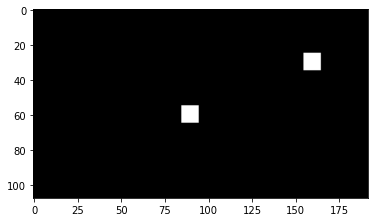

In [4]:
plt.imshow(heightmap, cmap='gray');

In [5]:
mask = np.zeros((108, 192), dtype=np.float32)

y0, x0 = 107, 96
y1 = 0

for x1 in range(192):
    bresenham(mask, heightmap, x0, y0, x1, y1)

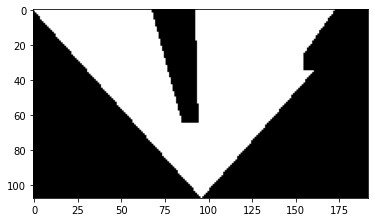

In [6]:
plt.imshow(mask, cmap='gray');

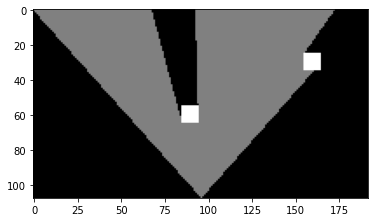

In [7]:
plt.imshow(np.where(mask == 1., 0.5, heightmap), cmap='gray');

In [8]:
centre_y, centre_x = 120, 96
radius = 120

dist_x = np.tile(np.arange(192), (108, 1)) - centre_x
dist_y = np.tile(np.arange(108).reshape(108, 1), (1, 192)) - centre_y

endpoints = np.abs(np.sqrt(np.power(dist_x, 2) + np.power(dist_y, 2)) - radius) < 0.72

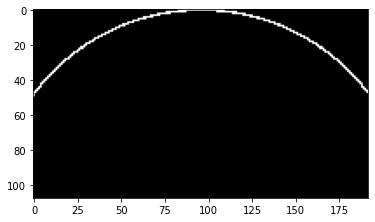

In [9]:
plt.imshow(endpoints, cmap='gray');

In [10]:
mask = np.zeros((108, 192), dtype=np.float32)

y0, x0 = 107, 96
y1 = 0

for y1, x1 in zip(*np.where(endpoints)):
    bresenham(mask, heightmap, x0, y0, x1, y1)

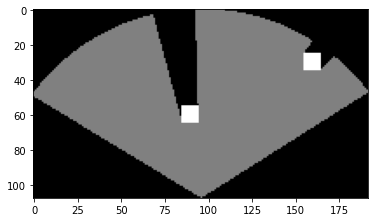

In [11]:
plt.imshow(np.where(mask == 1., 0.5, heightmap), cmap='gray');

### Traced ray endpoint indices

References:
- 3kliksphilip: CS GO's FOV - Your resolution matters | https://www.youtube.com/watch?v=YJIqFxgaXtY

In [12]:
endpoints = cv2.imread('../sidegame/assets/views/endpoints.png', cv2.IMREAD_GRAYSCALE)

In [13]:
def fov_endpoints(fov_deg, radius=108.):
    fov_rad = fov_deg * np.pi / 180.

    fov_threshold = radius * (1. - np.cos(fov_rad / 2.))
    fov_threshold = int(np.ceil(fov_threshold))

    endpoints_ = endpoints.copy()
    endpoints_[fov_threshold:] = 0

    return endpoints_

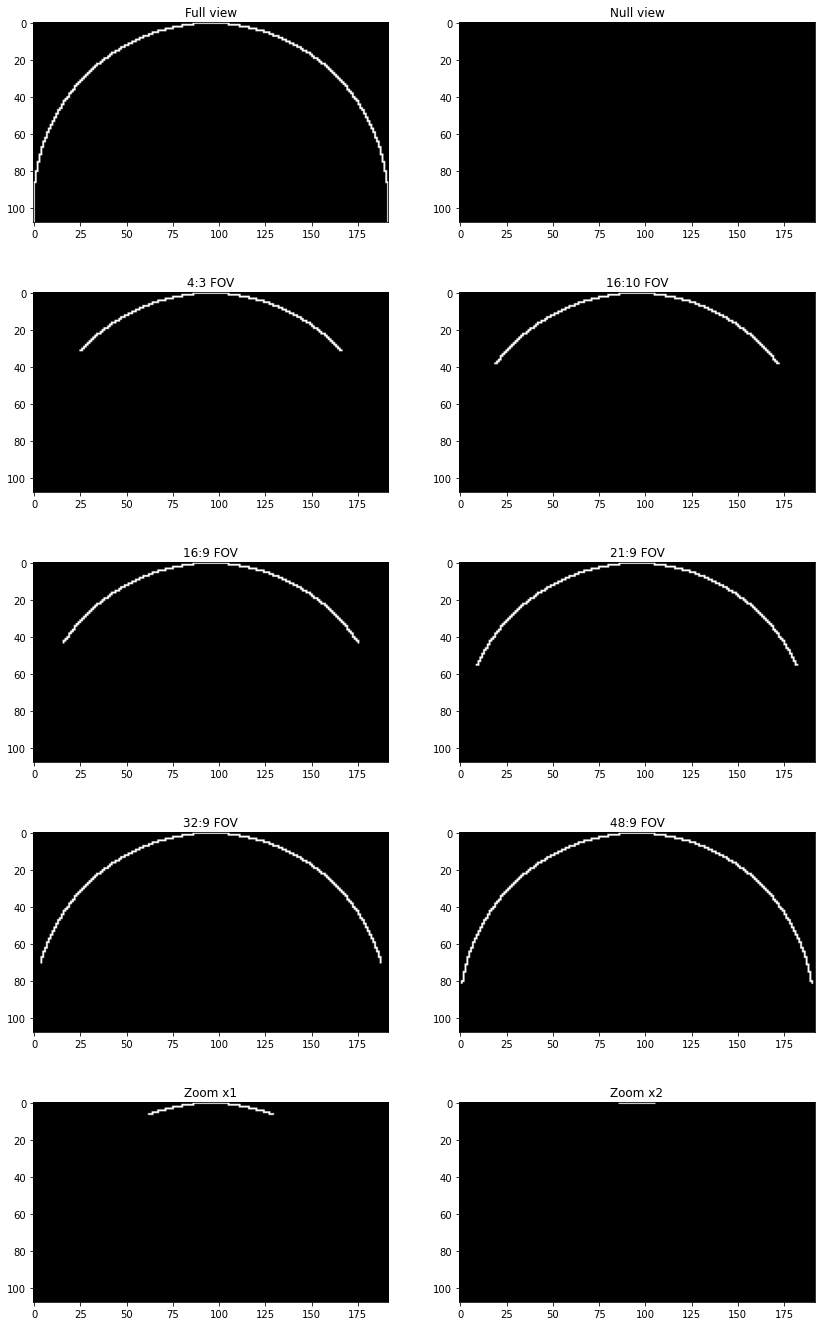

In [14]:
_, axes = plt.subplots(5, 2, figsize=(14, 24))

fov_degs = [180., 0., 90., 100.4, 106.3, 121.3, 138.9, 151.9, 40., 10.]
titles = ['Full view', 'Null view', '4:3 FOV', '16:10 FOV', '16:9 FOV', '21:9 FOV', '32:9 FOV', '48:9 FOV', 'Zoom x1', 'Zoom x2']

for i, (fov_deg, title) in enumerate(zip(fov_degs, titles)):
    ax = axes[i // 2, i % 2]
    ax.imshow(fov_endpoints(fov_deg), cmap='gray')
    ax.set_title(title);

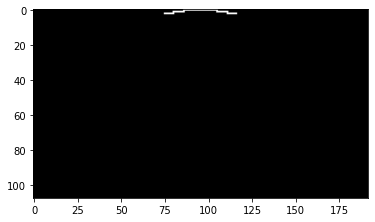

In [15]:
# Zoom middle ground
plt.imshow(fov_endpoints(25.), cmap='gray');

Because the frame width is even, there will be two pixels of origin, from which the rays will be traced, i.e. separately for the left and right sides.

In [16]:
endpoints_left, endpoints_right = np.hsplit(endpoints, 2)

In [17]:
el_idy, el_idx = np.where(endpoints_left)
er_idy, er_idx = np.where(endpoints_right)

halfwidth = endpoints.shape[1] // 2
er_idx += halfwidth

In [18]:
endpoints_ = endpoints.copy()
endpoints_[el_idy, el_idx] = 127

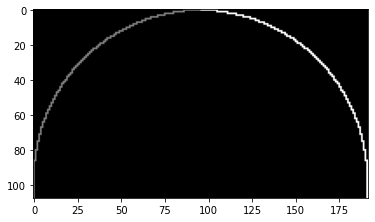

In [19]:
plt.imshow(endpoints_, cmap='gray');

In [20]:
endpoints_ = endpoints.copy()
endpoints_[er_idy, er_idx] = 127

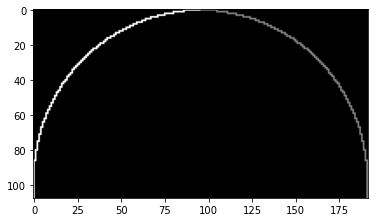

In [21]:
plt.imshow(endpoints_, cmap='gray');

In [22]:
def get_ray_endpoint_indices(endpoint_img, fov_deg, radius=108.):
    fov_rad = fov_deg * np.pi / 180.
    fov_threshold = int(np.ceil(radius * (1. - np.cos(fov_rad / 2.))))

    endpoint_img = endpoint_img.copy()
    endpoint_img[fov_threshold:] = 0

    left_half_img, right_half_img = np.hsplit(endpoint_img, 2)

    left_half_idy, left_half_idx = np.nonzero(left_half_img)
    right_half_idy, right_half_idx = np.nonzero(right_half_img)

    right_half_idx += endpoint_img.shape[1] // 2

    return left_half_idy, left_half_idx, right_half_idy, right_half_idx

In [23]:
standard_endpoint_indices = get_ray_endpoint_indices(endpoints, 106.3)
scoped_endpoint_indices = get_ray_endpoint_indices(endpoints, 25.)

In [24]:
endpoints_ = endpoints.copy()
endpoints_[standard_endpoint_indices[0], standard_endpoint_indices[1]] = 127
endpoints_[standard_endpoint_indices[2], standard_endpoint_indices[3]] = 192

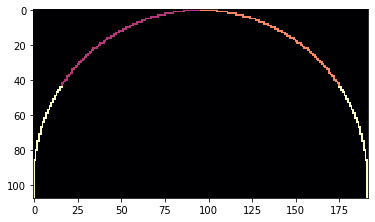

In [25]:
plt.imshow(endpoints_, cmap='magma', interpolation='nearest');

In [26]:
endpoints_ = endpoints.copy()
endpoints_[scoped_endpoint_indices[0], scoped_endpoint_indices[1]] = 127
endpoints_[scoped_endpoint_indices[2], scoped_endpoint_indices[3]] = 192

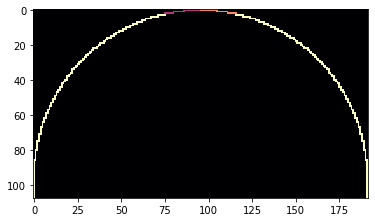

In [27]:
plt.imshow(endpoints_, cmap='magma', interpolation='nearest');

### Local frame transformation

References:
- https://github.com/jrosebr1/imutils/blob/master/imutils/convenience.py#L41

In [28]:
def rotate_bound(image, angle):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH), flags=cv2.INTER_NEAREST)

In [29]:
framed_heightmap = heightmap.copy()

framed_heightmap[:, 0] = 1.
framed_heightmap[:, -1] = 1.
framed_heightmap[0, :] = 1.
framed_heightmap[-1, :] = 1.

rot_heightmap = rotate_bound(framed_heightmap, -30.)

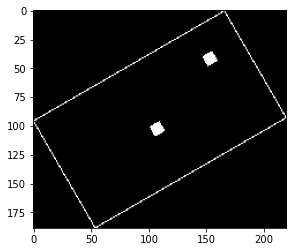

In [30]:
plt.imshow(rot_heightmap, cmap='gray');

In [31]:
global_heightmap = np.pad(rot_heightmap, 200, mode='constant', constant_values=0.)

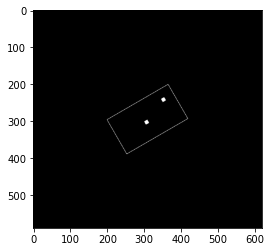

In [32]:
plt.imshow(global_heightmap, cmap='gray');

In [33]:
rot_heightmap_padded = rotate_bound(global_heightmap, 30.)

centre_y, centre_x = rot_heightmap_padded.shape[0] // 2, rot_heightmap_padded.shape[1] // 2
local_heightmap = rot_heightmap_padded[centre_y-54:centre_y+54, centre_x-96:centre_x+96]

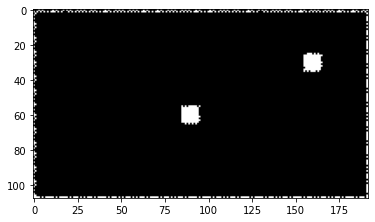

In [34]:
plt.imshow(local_heightmap, cmap='gray');

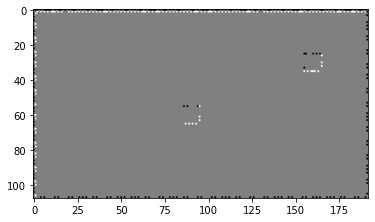

In [35]:
plt.imshow(local_heightmap - framed_heightmap, cmap='gray');